In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from tqdm.notebook import tqdm

import logging
logging.getLogger().setLevel(logging.ERROR)

In [2]:
def normalize(x):
    return x / np.linalg.norm(x, ord=2, keepdims=True)

def Q(x):
    return 1 - scipy.stats.norm.cdf(x)

def natErr(v, mu, sigma_diag):
    return Q(v @ mu / np.sqrt((v * v) @ sigma_diag))

def robErr(v, mu, sigma_diag):
    return Q((v @ mu - np.sqrt((v * v).sum(axis=-1))) / np.sqrt((v * v) @ sigma_diag))

def natRobErrs(v, mu, sigma_diag):
    print(robErr(v=v, mu=mu, sigma_diag=sigma_diag).shape)
    return np.stack((
        natErr(v=v, mu=mu, sigma_diag=sigma_diag),
        robErr(v=v, mu=mu, sigma_diag=sigma_diag)
    ), axis=-1)

natRobErrs(v=np.arange(15).reshape(3, 5), mu=np.arange(5) + 1, sigma_diag=1 + np.arange(5))

(3,)


array([[2.25547674e-04, 1.23151127e-03],
       [6.59913113e-05, 4.97545215e-04],
       [5.80201904e-05, 4.72775462e-04]])

In [3]:
def sigmoidspace(lo, hi, n, scale=1):
    """https://stackoverflow.com/a/57104178/1337463"""
    raw = np.tanh(np.linspace(-scale, scale, n))
    raw_01 = (raw - raw[0]) / (raw[-1] - raw[0]) 
    return lo + (hi - lo) * raw_01

def s_func(mu, sigma_diag, ws):
    xs = (ws @ mu) / np.sqrt((ws * ws) @ sigma_diag)
    ys = np.sqrt((ws * ws).sum(axis=-1)) / np.sqrt((ws * ws) @ sigma_diag)
    return np.stack((xs, ys), axis=0)

def rs_to_errs(rs, attack_eps):
    nat_err = Q(rs[0])
    rob_err = Q(rs[0] - attack_eps*rs[1])
    return np.stack((nat_err, rob_err), axis=0)

def w_lam_rob(mu, sigma_diag, attack_eps):
    lam_lo = -1 / sigma_diag.max()
    lam_hi = 1e9
    for i in range(64):
        lam_mid = (lam_lo + lam_hi) / 2
        
        w_mid = mu / (1 + lam_mid * sigma_diag)
        if np.sqrt(w_mid @ w_mid) < attack_eps:
            lam_hi = lam_mid
        else:
            lam_lo = lam_mid
    
    return mu / (1 + lam_lo * sigma_diag), lam_lo

# Begin plots

In [4]:
def rolling(xs, ys, window_size: float):
    """xs lie in [0, 1] and are sorted"""
    s = pd.Series(index=pd.to_datetime(1e9*xs), data=ys)
    return s.rolling(
        window=datetime.timedelta(seconds=window_size),
        min_periods=1
    )

def get_boundary(pts, window_size=1e-2):
    """pts of shape (n, 2)"""
    assert pts.shape[1] == 2
    
    srt_indices = np.lexsort((pts[:, 1], pts[:, 0]))
    pts = pts[srt_indices]
        
    xs = pts[:, 0]
    ys = pts[:, 1]
    ys_lo = rolling(xs=xs, ys=ys, window_size=window_size).min().to_numpy()
    ys_hi = rolling(xs=xs, ys=ys, window_size=window_size).max().to_numpy()
    
    return xs, ys_lo, ys_hi

def plot_pts_boundary(rs, attack_eps, window_size, **plt_kwargs):
    assert rs.shape[1] == 2
    window_size *= rs[:,0].max()
    xs, ys_lo, ys_hi = get_boundary(rs, window_size=window_size)
    
    qxs, qys_lo, qys_hi = Q(xs), Q(xs - attack_eps*ys_lo), Q(xs - attack_eps*ys_hi)
    # from https://stackoverflow.com/a/54256731/1337463
    plt.fill(
        np.append(qxs, qxs[::-1]),
        np.append(qys_lo, qys_hi[::-1]),
        **plt_kwargs,
    )

1.9230523587162613
1.3056626968402973
-0.15602473441030837


Text(0, 0.5, 'rob err')

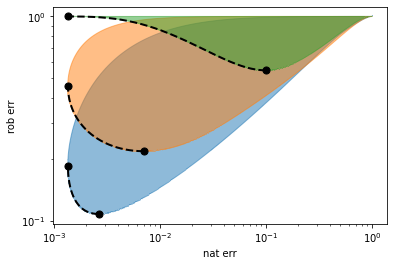

In [5]:
def plot_joint_region(
    dim: int,
    mu_scale,
    attack_eps: float,
    seed: int,
    #color: str,
    debug: bool = False,
    #alpha_shape_alpha: float = 5,
    num_samples: int = 100000,
    sigmoid_scale: float = 7,
    window_size: float = 3e-4,
    region_plt_kwargs: dict = None,
):
    np.random.seed(seed)
    D = dim

    #SLO = 1e-3
    #SHI=10
    #Sigma = 1 + np.arange(D)
    Sigma = np.sort(np.log(1 + np.abs(np.random.normal(size=D))))
    #Sigma = np.sort(np.concatenate(([SLO, SHI], SLO + (SHI-SLO)*np.random.random(size=D-2))))
    
    mu = np.random.normal(size=D)
    #mu[:-1] = 1e-2
    #mu[:0] = 1
    mu /= np.sqrt((mu / Sigma) @ mu)
    mu *= mu_scale
    
    EPS = 1e-9
    MX = 100 * 1 / Sigma[0]
    NUM_FRONT = 1
    NUM_BACK = 1
    lambdas = np.concatenate([
        sigmoidspace(lo=-MX, hi=-1/Sigma[0] - EPS, n=num_samples, scale=sigmoid_scale),
        sigmoidspace(lo=-1/Sigma[-1] + EPS, hi=MX, n=num_samples, scale=sigmoid_scale),
    ] + [
        sigmoidspace(lo=-1/z1 + EPS, hi=-1/z2 - EPS, n=num_samples, scale=sigmoid_scale)
        for z1, z2 in zip(Sigma[:NUM_FRONT], Sigma[1:1+NUM_FRONT])
    ] + ([] if NUM_BACK == 0 else [
        sigmoidspace(lo=-1/z1 + EPS, hi=-1/z2 - EPS, n=num_samples, scale=sigmoid_scale)
        for z1, z2 in zip(Sigma[-NUM_BACK-1:], Sigma[-NUM_BACK:])
    ]))
    
    w_rob, lam_rob = w_lam_rob(mu=mu, sigma_diag=Sigma, attack_eps=attack_eps)
    print(lam_rob)
    lambdas_eff = sigmoidspace(lo=lam_rob, hi=MX, n=num_samples, scale=10)
    ws_eff = 1 / (1 + lambdas_eff[:, np.newaxis] * Sigma[np.newaxis, :]) * mu[np.newaxis, :]
    
    ws_bound = 1 / (1 + lambdas[:, np.newaxis] * Sigma[np.newaxis, :]) * mu[np.newaxis, :]
    ws_bound = np.concatenate([ws_bound, -ws_bound, ws_eff])
    
    rs_bound = s_func(mu=mu, sigma_diag=Sigma, ws=ws_bound)
    plot_pts_boundary(rs_bound.T, window_size=window_size, attack_eps=attack_eps, **region_plt_kwargs)
    #alpha_shape = alphashape.alphashape(errs_bound.T, alpha_shape_alpha)
    #plt.gca().add_patch(PolygonPatch(alpha_shape, alpha=0.4, color=color))
    if debug:
        errs_bound = rs_to_errs(
            rs=rs_bound,
            attack_eps=attack_eps
        )
        plt.scatter(errs_bound[0], errs_bound[1], s=3)
    
    #ws_random = np.random.normal(size=(10000, D))
    #rs_random = s_func(mu=mu, sigma_diag=Sigma, ws=ws_random)
    #plt.scatter(Q(rs_random[0]), Q(rs_random[0] - attack_eps*rs_random[1]), s=3)
    
    errs_eff = rs_to_errs(
        rs=s_func(mu=mu, sigma_diag=Sigma, ws=ws_eff),
        attack_eps=attack_eps
    )
    plt.plot(errs_eff[0], errs_eff[1], color="black", linestyle="--", linewidth=2, zorder=10)
    
    r_rob = s_func(mu=mu, sigma_diag=Sigma, ws=w_rob)
    r_nat = s_func(mu=mu, sigma_diag=Sigma, ws=mu / Sigma)
    plt.scatter(Q(r_rob[0]), Q(r_rob[0] - attack_eps * r_rob[1]), s=50, color="black", zorder=10)
    plt.scatter(Q(r_nat[0]), Q(r_nat[0] - attack_eps * r_nat[1]), s=50, color="black", zorder=10)
    
    plt.yscale("log")
    plt.xscale("log")
        
# Cool seeds: 19
plot_joint_region(dim=32, mu_scale=3, attack_eps=1, seed=18, region_plt_kwargs=dict(color="tab:blue", alpha=0.5))
plot_joint_region(dim=32, mu_scale=3, attack_eps=1, seed=20, region_plt_kwargs=dict(color="tab:orange", alpha=0.5))
plot_joint_region(dim=32, mu_scale=3, attack_eps=1, seed=21, region_plt_kwargs=dict(color="tab:green", alpha=0.5))
plt.xlabel("nat err")
plt.ylabel("rob err")

2.2910378392050115
1.0302889796579775
0.8038435128260082
1.0937266915683534


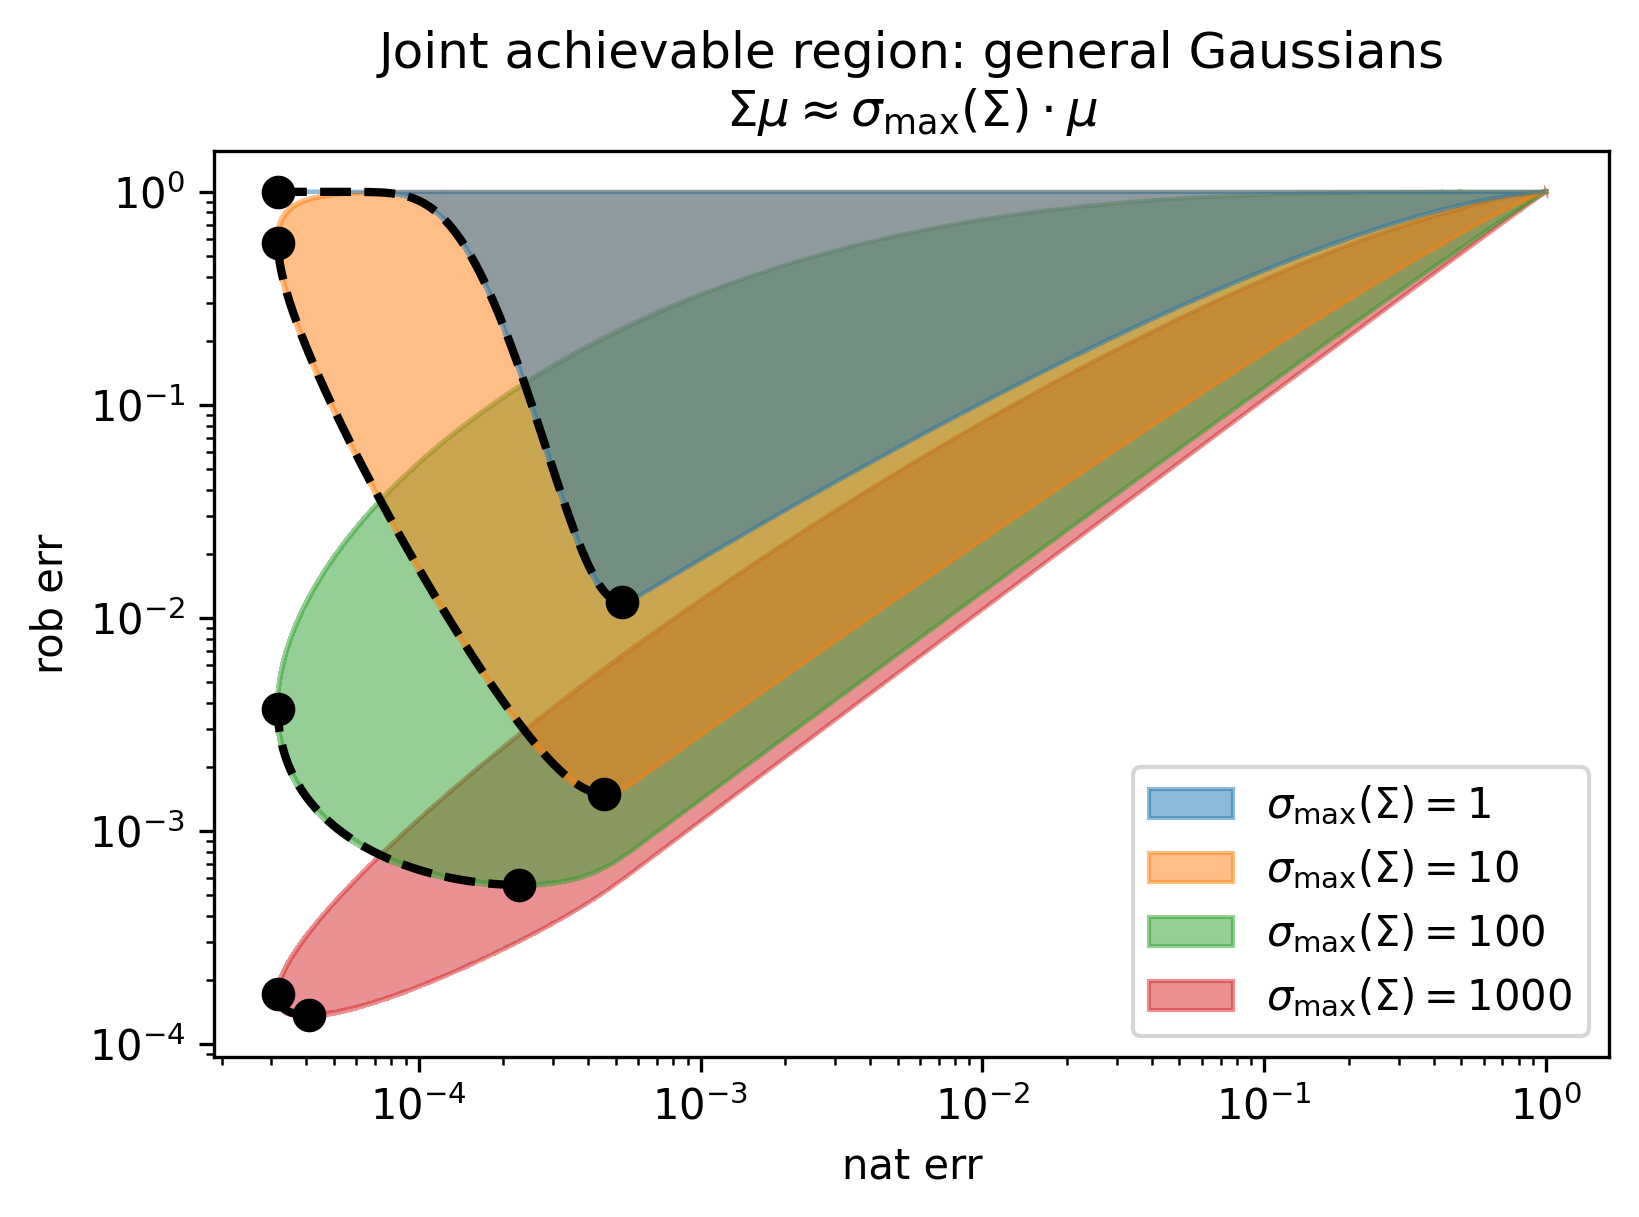

In [6]:
def plot_joint_region2(
    dim: int, sig_lo: float, sig_hi: float, target_mu_idx: int,
    mu_scale,
    attack_eps: float,
    seed: int,
    #color: str,
    debug: bool = False,
    #alpha_shape_alpha: float = 5,
    num_samples: int = 100000,
    sigmoid_scale: float = 7,
    window_size: float = 3e-4,
    region_plt_kwargs: dict = None,
):
    np.random.seed(seed)
    D = dim

    Sigma = np.exp(np.linspace(np.log(sig_lo), np.log(sig_hi), num=dim))
    #Sigma = np.linspace(sig_lo, sig_hi, num=dim)
    
    mu = np.random.normal(size=D)
    #mu[:-1] = 1e-2
    mu[target_mu_idx] = 100
    mu /= np.sqrt((mu / Sigma) @ mu)
    mu *= mu_scale
    
    EPS = 1e-9
    MX = 100 * 1 / Sigma[0]
    NUM_FRONT = 1
    NUM_BACK = 1
    lambdas = np.concatenate([
        sigmoidspace(lo=-MX, hi=-1/Sigma[0] - EPS, n=num_samples, scale=sigmoid_scale),
        sigmoidspace(lo=-1/Sigma[-1] + EPS, hi=MX, n=num_samples, scale=sigmoid_scale),
    ] + [
        sigmoidspace(lo=-1/z1 + EPS, hi=-1/z2 - EPS, n=num_samples, scale=sigmoid_scale)
        for z1, z2 in zip(Sigma[:NUM_FRONT], Sigma[1:1+NUM_FRONT])
    ] + ([] if NUM_BACK == 0 else [
        sigmoidspace(lo=-1/z1 + EPS, hi=-1/z2 - EPS, n=num_samples, scale=sigmoid_scale)
        for z1, z2 in zip(Sigma[-NUM_BACK-1:], Sigma[-NUM_BACK:])
    ]))
    
    w_rob, lam_rob = w_lam_rob(mu=mu, sigma_diag=Sigma, attack_eps=attack_eps)
    print(lam_rob)
    lambdas_eff = sigmoidspace(lo=lam_rob, hi=MX, n=num_samples, scale=10)
    ws_eff = 1 / (1 + lambdas_eff[:, np.newaxis] * Sigma[np.newaxis, :]) * mu[np.newaxis, :]
    
    ws_bound = 1 / (1 + lambdas[:, np.newaxis] * Sigma[np.newaxis, :]) * mu[np.newaxis, :]
    ws_bound = np.concatenate([ws_bound, -ws_bound, ws_eff])
    
    rs_bound = s_func(mu=mu, sigma_diag=Sigma, ws=ws_bound)
    plot_pts_boundary(rs_bound.T, window_size=window_size, attack_eps=attack_eps, **region_plt_kwargs)
    #alpha_shape = alphashape.alphashape(errs_bound.T, alpha_shape_alpha)
    #plt.gca().add_patch(PolygonPatch(alpha_shape, alpha=0.4, color=color))
    if debug:
        errs_bound = rs_to_errs(
            rs=rs_bound,
            attack_eps=attack_eps
        )
        plt.scatter(errs_bound[0], errs_bound[1], s=3)
    
    #ws_random = np.random.normal(size=(10000, D))
    #rs_random = s_func(mu=mu, sigma_diag=Sigma, ws=ws_random)
    #plt.scatter(Q(rs_random[0]), Q(rs_random[0] - attack_eps*rs_random[1]), s=3)
    
    errs_eff = rs_to_errs(
        rs=s_func(mu=mu, sigma_diag=Sigma, ws=ws_eff),
        attack_eps=attack_eps
    )
    plt.plot(errs_eff[0], errs_eff[1], color="black", linestyle="--", linewidth=2, zorder=10)
    
    r_rob = s_func(mu=mu, sigma_diag=Sigma, ws=w_rob)
    r_nat = s_func(mu=mu, sigma_diag=Sigma, ws=mu / Sigma)
    plt.scatter(Q(r_rob[0]), Q(r_rob[0] - attack_eps * r_rob[1]), s=50, color="black", zorder=10)
    plt.scatter(Q(r_nat[0]), Q(r_nat[0] - attack_eps * r_nat[1]), s=50, color="black", zorder=10)
        
# Cool seeds: 19
plt.figure(dpi=300)

for idx, sig_hi in enumerate([1, 10, 100, 1000]):
    plot_joint_region2(dim=32, sig_lo=sig_hi/1000, sig_hi=sig_hi, target_mu_idx=-1, mu_scale=4, attack_eps=1, seed=20,
                       region_plt_kwargs=dict(color=f"C{idx}", alpha=0.5, label="$\sigma_\mathrm{max}(\Sigma)="+f"{sig_hi}"+"$", zorder=5-idx))

plt.yscale("log")
plt.xscale("log")
plt.title("Joint achievable region: general Gaussians\n$\Sigma\mu\\approx\sigma_\mathrm{max}(\Sigma)\cdot\mu$");
plt.xlabel("nat err")
plt.ylabel("rob err")
plt.legend(bbox_to_anchor=(1, 0), loc='lower right', ncol=1);

-0.9869619288759318
3.857612717647442
1.8565433691041762
0.6726247263668782


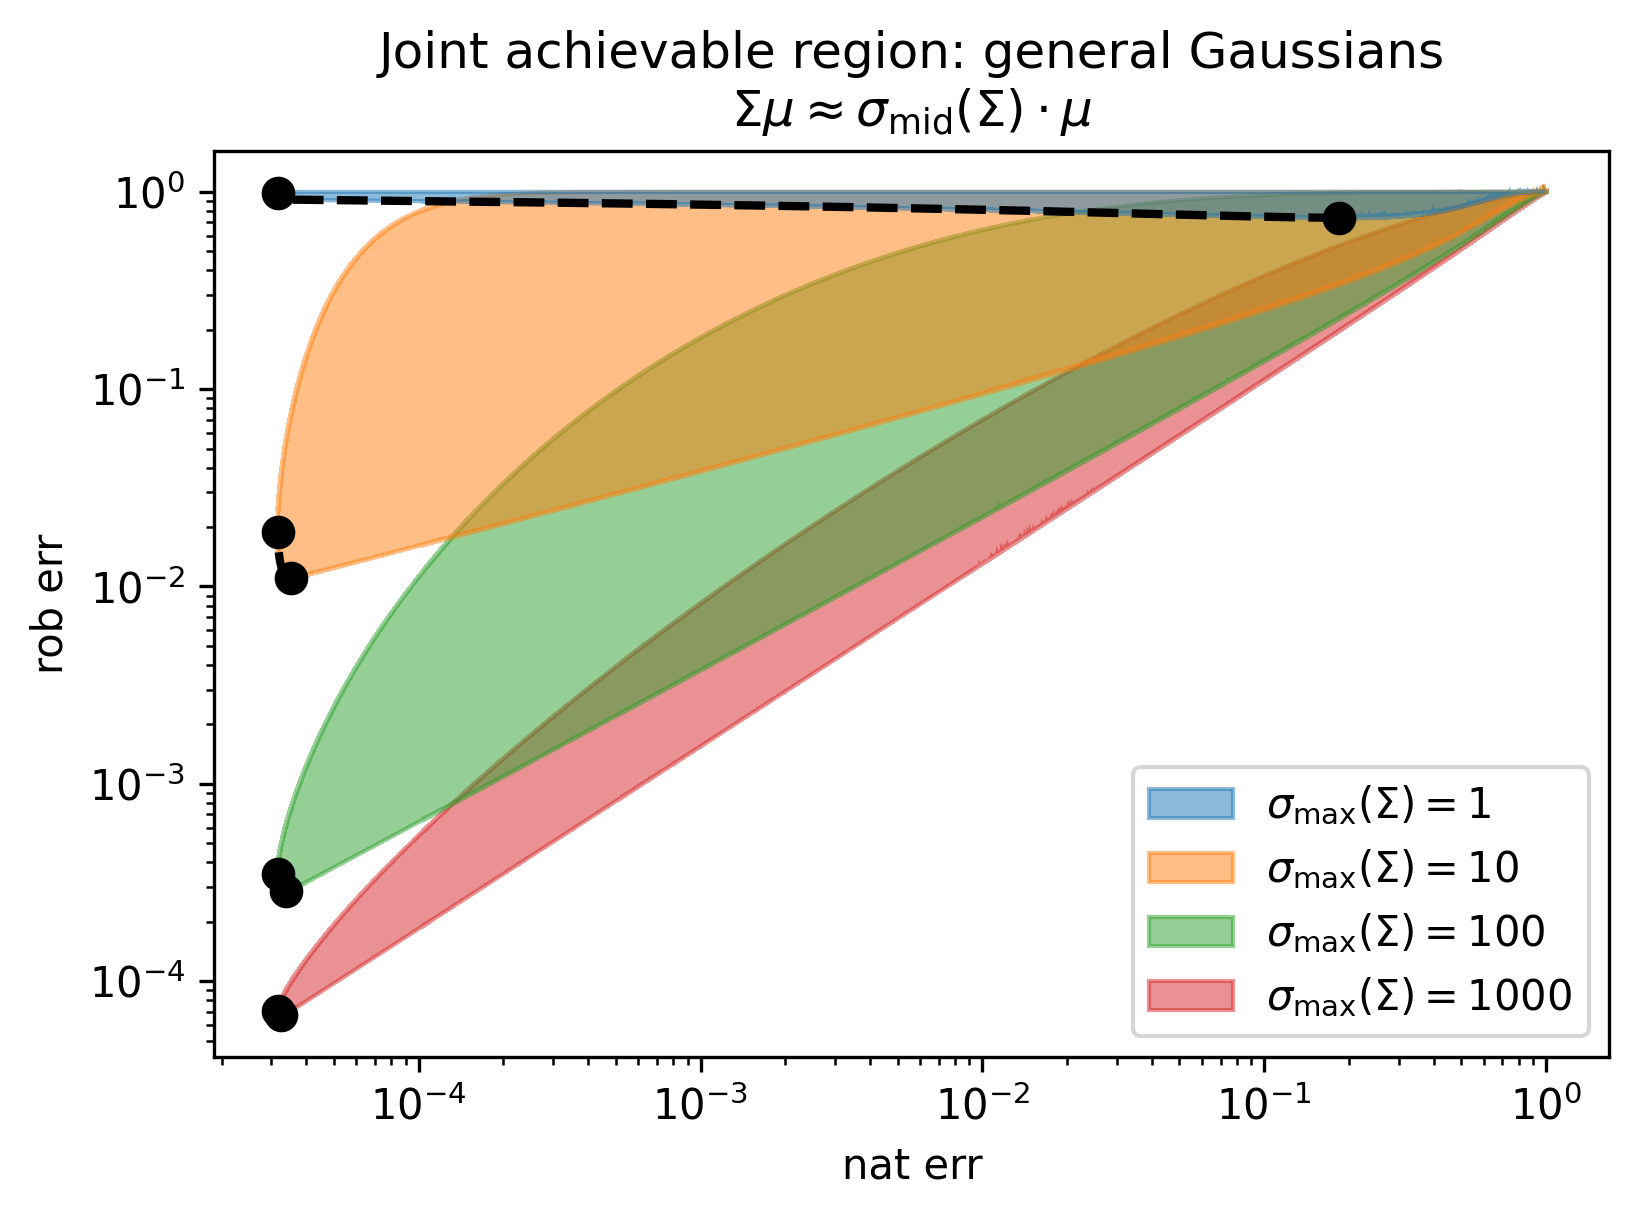

In [7]:
plt.figure(dpi=300)

for idx, sig_hi in enumerate([1, 10, 100, 1000]):
    plot_joint_region2(dim=32, sig_lo=sig_hi/1000, sig_hi=sig_hi, target_mu_idx=16, mu_scale=4, attack_eps=1, seed=20,
                       region_plt_kwargs=dict(color=f"C{idx}", alpha=0.5, label="$\sigma_\mathrm{max}(\Sigma)="+f"{sig_hi}"+"$", zorder=5-idx))

plt.yscale("log")
plt.xscale("log")
plt.title("Joint achievable region: general Gaussians\n$\Sigma\mu\\approx\sigma_\mathrm{mid}(\Sigma)\cdot\mu$");
plt.xlabel("nat err")
plt.ylabel("rob err")
plt.legend(bbox_to_anchor=(1, 0), loc='lower right', ncol=1);

-0.09951753111739783
-0.019548857404487592
2.6499705578082198
2.9996146755699202


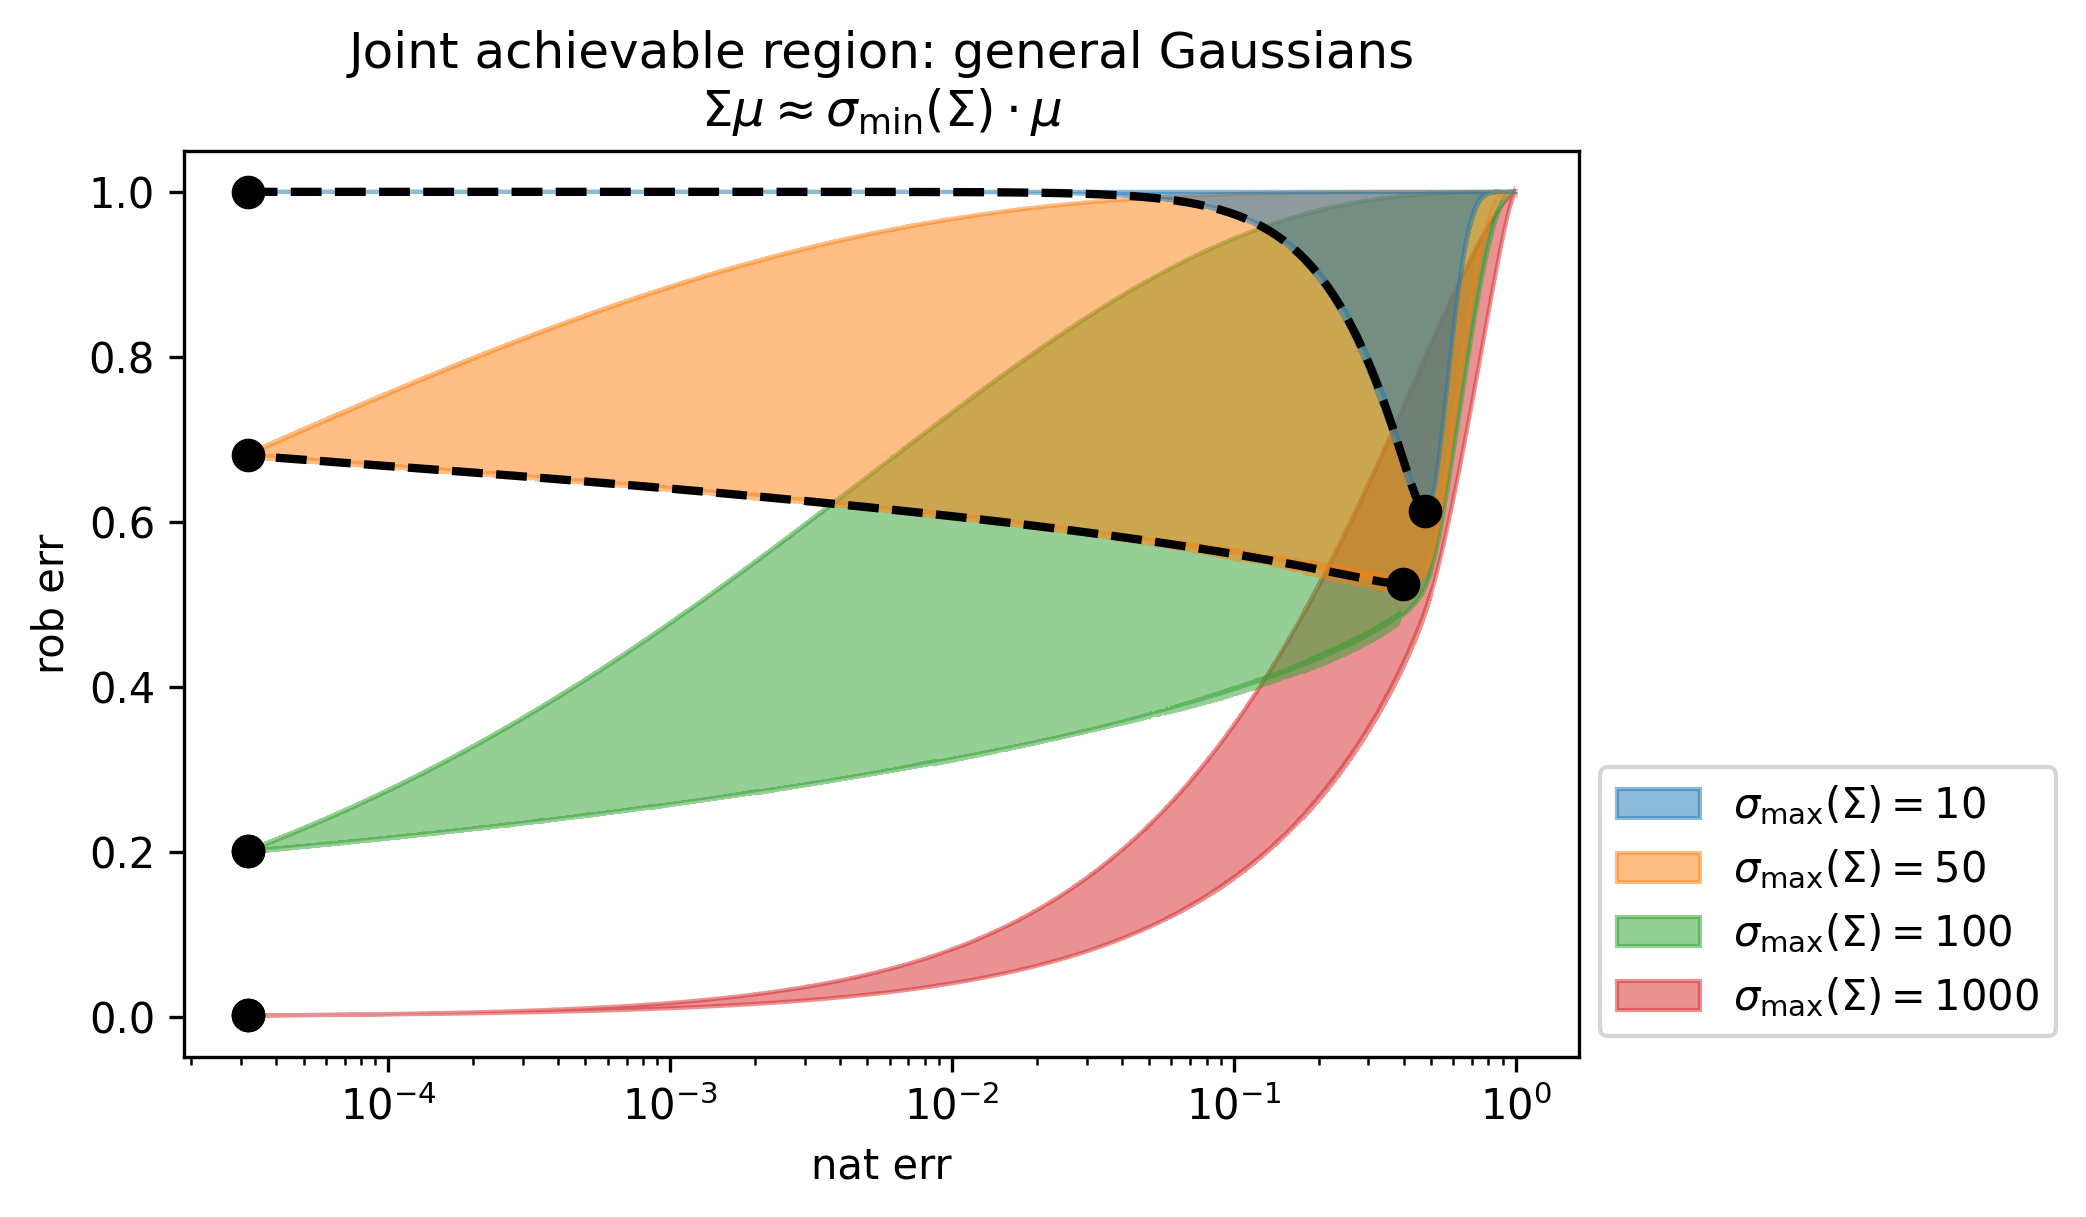

In [8]:
plt.figure(dpi=300)

for idx, sig_hi, in enumerate([10, 50, 100, 1000]):
    plot_joint_region2(dim=32, sig_lo=sig_hi/1000, sig_hi=sig_hi, target_mu_idx=0, mu_scale=4, attack_eps=1, seed=20,
                       region_plt_kwargs=dict(color=f"C{idx}", alpha=0.5, label="$\sigma_\mathrm{max}(\Sigma)="+f"{sig_hi}"+"$", zorder=5-idx))

#plt.yscale("log")
plt.xscale("log")
plt.title("Joint achievable region: general Gaussians\n$\Sigma\mu\\approx\sigma_\mathrm{min}(\Sigma)\cdot\mu$");
plt.xlabel("nat err")
plt.ylabel("rob err")
plt.legend(bbox_to_anchor=(1, 0), loc='lower left', ncol=1);